# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Hugging Face Hub Link:**

- Link: https://huggingface.co/sameerhashmi36/upside_down_model_using_resnet/tree/main

**Final Model Link:**
 
  - Model Link: https://huggingface.co/sameerhashmi36/upside_down_model_using_resnet/commit/32dee3fae3b16a88c8f3347b0bdaee0653448841

### Import libraries

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

In [ ]:
from albumentations.pytorch import ToTensor

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
cudnn.benchmark = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd content/drive/MyDrive/upside_down/

[Errno 2] No such file or directory: 'content/drive/MyDrive/upside_down/'
/content


In [ ]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 136 kB 44.6 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 45.8 MB/s 
     |████████████████████████████████| 1.1 MB 31.6 MB/s 
     |████████████████████████████████| 127 kB 47.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 45.7 MB/s 
     |████████████████████████████████| 144 kB 42.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("cifar100")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# dataset.__dir__()

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

### Deviding Images for Upside down

In [ ]:
from PIL import Image

In [ ]:
train_sample = dataset["train"]

In [ ]:
train_sample

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 50000
})

In [ ]:
test_sample = dataset["test"]

In [ ]:
test_sample[0]['fine_label']

49

In [ ]:
len(train_sample)

50000

In [ ]:
import random

In [ ]:
# label0 = 0
# train_split_normal = []
# train_split = len(train_sample)//2
# print(train_split)
# for x in range(train_split):
#   train_split_normal.append((x,label0))
# print(train_split_normal)

### Train and Test data randomly labeling

In [ ]:
# train_indices = [(i, random.randint(0,1)) for i in range(50000)]

In [ ]:
# test_indices = [(i, random.randint(0,1)) for i in range(10000)]

### Dataset Class

In [ ]:
class DatasetClass(Dataset):
    def __init__(self, dataset, field='image', transform=None): #data_indices
        self.dataset = dataset
        # self.data_labeled_indices = data_indices
        self.field = field
        self.transform = transform
        
    def __len__(self):
        return self.dataset.num_rows

    def __getitem__(self, idx):
        # image_idx, label = self.data_labeled_indices[idx]
        label = random.randint(0,1)
        image = self.dataset[idx][self.field]
        
        # 0 = normal image
        if label == 0:
            image = self.transform(image)
            label = torch.tensor(label) #ToTensor()(label)
            
            # encountered a single channel image in food dataset
            # if image.shape[0]==3:
            #     return image, label
            # else:
            #     image = [image]*3
            return image, label
        # 1 = flipped image/upside down
        else:
            flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)
            flipped_image = self.transform(flipped_image)
            label = torch.tensor(label) #ToTensor()(label)
            return flipped_image, label

### Data normalizing

In [ ]:
normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                                 ])

In [ ]:
train_data = DatasetClass(dataset['train'], field='img', transform=normalize)
test_data = DatasetClass(dataset['test'], field='img',  transform=normalize)

In [ ]:
x_train, y_train = train_data[3]

In [ ]:
x_train.shape

torch.Size([3, 32, 32])

### Data Loader

In [ ]:
params = {
    "model": "resnet18",
    "feature_dimension": 512,
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 25,
}

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=params['batch_size'], shuffle=False)

In [ ]:
stream = next(iter(train_dataloader))

In [ ]:
x, y = stream

In [ ]:
x.shape

torch.Size([128, 3, 32, 32])

### Custom Pretrained Model

In [ ]:
class CustomPretrainedModel(nn.Module):
    def __init__(self, model_name=params["model"], feature_dim=params["feature_dimension"], class_number=1):
        super(CustomPretrainedModel, self).__init__()
        self.model_name = model_name
        self.feature_dim = feature_dim
        self.class_number = class_number
        self.ready_model = self.model_return()

    def model_return(self):
        pre_model = getattr(models, self.model_name)(pretrained=True)
        print(pre_model)
        pre_model.fc = nn.Identity()
        pre_model.fc = nn.Linear(in_features=self.feature_dim, out_features=self.class_number, bias=True)
        return pre_model

    def forward(self, x):
        output = self.ready_model(x)
        return output

In [ ]:
# class CustomPretrainedModelWithDropout(nn.Module):
#     def __init__(self, model_name=params["model"], feature_dim=params["feature_dimension"], class_number=1):
#         super(CustomPretrainedModelWithDropout, self).__init__()
#         self.model_name = model_name
#         self.feature_dim = feature_dim
#         self.class_number = class_number
#         self.ready_model = self.model_return()

#         # Define proportion or neurons to dropout
        
#         # self.dropout_fc = nn.Linear(in_features=self.feature_dim, out_features=1000, bias=True)
#         self.dropout = nn.Dropout(0.7)
#         self.last_fc = nn.Linear(in_features=512, out_features=self.class_number, bias=True)

#     def model_return(self):
#         pre_model = getattr(models, self.model_name)(pretrained=True)
#         print(pre_model)
#         pre_model.fc = nn.Identity()

#         return pre_model

#     def forward(self, x):
#         features = self.ready_model(x)
#         dropout_y = self.dropout(features)
#         y = self.last_fc(dropout_y)
        
#         return y

In [ ]:
ready_model = CustomPretrainedModelWithDropout()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
output = ready_model(x)

In [ ]:
output.shape

torch.Size([128, 1])

In [ ]:
ready_model

CustomPretrainedModelWithDropout(
  (ready_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentu

In [ ]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
model = ready_model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

### Training Pipeline

In [ ]:
# train_losses = []
# train_acc = []

def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        # train_losses.append(loss.item())
        metric_monitor.update("Accuracy", accuracy)
        # train_acc.append(accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'] #loss.item(), accuracy

### Validation Pipeline

In [ ]:
# val_losses = []
# val_acc = []

def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            # val_losses.append(loss.item())
            metric_monitor.update("Accuracy", accuracy)
            # val_acc.append(accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'] #loss.item(), accuracy

### Function for Saving Model

In [ ]:
def model_save(epoch, model, optimizer, PATH):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)

### Training Loop

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(train_dataloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(test_dataloader, model, criterion, epoch, params)
    # print("##########", train_loss, val_loss)
    # print("!!!!!!!!!", train_accuracy, val_accuracy)

    # if val_accuracy > prev_accuracy:
    model_save(epoch, model, optimizer, PATH = f"/content/drive/MyDrive/upside_down/resnet18/my_model_epoch_{epoch}.pth")

    prev_accuracy = val_accuracy

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Epoch: 1. Train.      Loss: 0.513 | Accuracy: 0.741: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s]
Epoch: 1. Validation. Loss: 0.351 | Accuracy: 0.839: 100%|██████████| 79/79 [00:09<00:00,  8.35it/s]
Epoch: 2. Train.      Loss: 0.311 | Accuracy: 0.861: 100%|██████████| 391/391 [00:52<00:00,  7.45it/s]
Epoch: 2. Validation. Loss: 0.292 | Accuracy: 0.867: 100%|██████████| 79/79 [00:09<00:00,  8.45it/s]
Epoch: 3. Train.      Loss: 0.246 | Accuracy: 0.896: 100%|██████████| 391/391 [00:51<00:00,  7.55it/s]
Epoch: 3. Validation. Loss: 0.275 | Accuracy: 0.882: 100%|██████████| 79/79 [00:09<00:00,  8.38it/s]
Epoch: 4. Train.      Loss: 0.197 | Accuracy: 0.918: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s]
Epoch: 4. Validation. Loss: 0.284 | Accuracy: 0.883: 100%|██████████| 79/79 [00:09<00:00,  8.37it/s]
Epoch: 5. Train.      Loss: 0.165 | Accuracy: 0.934: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s]
Epoch: 5. Validation. Loss: 0.269 | Accuracy: 0.892: 100%|██████████| 79/79 [00:0

**Train and Validation Accuracy:**

    - This time the models were not overfitted like the previous models.
    - Got the expecting model with 99.1% training accuracy and 90.6% validation accuracy in the epoch 24.


Training Loss and Validation Loss Curve

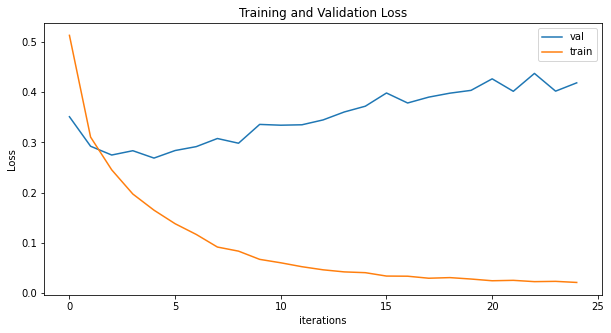

In [ ]:
############ Curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/upside_down/resnet18/images/train_and_val_loss_resnet18.jpg')
plt.show()

Training and Validation Accuracy Curve

In [ ]:
train_acc

In [ ]:
val_acc

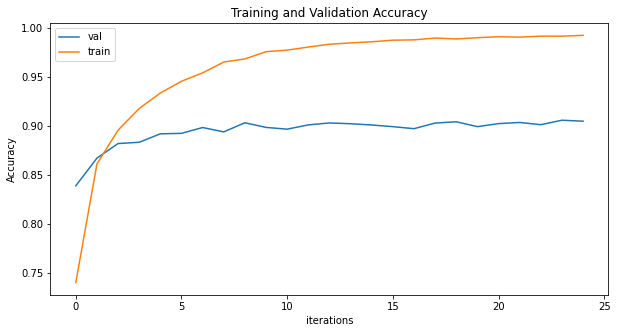

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/upside_down/resnet18/images/train_and_val_acc_resnet18.jpg')
plt.show()


### Load Model

In [ ]:
model_path = "/content/drive/MyDrive/upside_down/resnet18/my_model_epoch_24.pth"
# model.load_state_dict(torch.load(models, map_location=params['device']))

In [ ]:
checkpoint = torch.load(model_path, map_location=params['device'])

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:
# model

## Inference Pipeline

In [ ]:
dataset = load_dataset("cifar10")

Reusing dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
inference_indices = [(i, random.randint(0,1)) for i in range(dataset['train'].num_rows)]

In [ ]:
# model

In [ ]:
inferece_transform =  transforms.Compose([transforms.Lambda(lambda image: image.convert('RGB')), transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                                 ])


In [ ]:
inference_data = DatasetClass(dataset['train'], field='img', transform=inferece_transform)

In [ ]:
# inference_data[0]

In [ ]:
inference_dataloader = DataLoader(inference_data, batch_size=params['batch_size'], shuffle=False)

In [ ]:
# batch = next(iter(inference_dataloader))

In [ ]:
# batch

In [ ]:
# model(batch[0])

### Test Accuracy

In [ ]:
from sklearn.metrics import f1_score, precision_score

In [ ]:
def calculate_metrics(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item(), f1_score(target, output), precision_score(target, output)

In [ ]:
def test(test_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            accuracy, f1_score_var, precision = calculate_metrics(output, target)
            # print(accuracy, f1_score_var, precision)
            # break
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1-Score", f1_score_var)
            metric_monitor.update("Precision-", precision)
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return accuracy, f1_score

In [ ]:
test_accuracy, _ = test(inference_dataloader, model, criterion, epoch, params)

Epoch: 24. Test. Loss: 0.016 | Accuracy: 0.994 | F1-Score: 0.994 | Precision-: 0.993: 100%|██████████| 391/391 [00:51<00:00,  7.61it/s]


**Test Accuracy:**
  - I have tested the inference dataset using 'cifar10' and it's working perfectly and got accuracy almost 82% using the highest validtion accuracy model name 'my_model_epoch_6.pth' where Dropout has been used with resnet18 pretrained model before the linear layer(modified the out_feature=1).
  - As you can see almost 82% of the 'cifar10' dataset has been predicted true but almost 18% of the dataset has been predicted wrong but this can be improved. Most of the models are being overfitted but I have chosen a best fitted model among the other models/epoch.
  - The models are becoming bias on human images.
  - I have also tested 'food101' dataset in inference time but the models couldn't predict the right image because 'cifar100' doesn't have food images.
  - I also have try to label the images randomly during training time that helped me to get some more accuracy.
  - If I use dropout in every layer then it might be possible that the train and test accuracy will increase.
  - I also trained models in resnet34 and resnet50 but got very bad result.
  - At last I have trained the model using resnet18 without Dropout but using the random labeling on the fly and got best results till now.
  - In epoch-24 the train and validation accuracy is consecutively 0.991 and 0.906 and inference accuracy is 99.4% on 'cifar10' dataset which is till now best accuracy I have gotten.

### Image Testing(Visualization)

In [ ]:
from PIL import Image

In [ ]:
inferece_transform_visual =  transforms.Compose([transforms.Lambda(lambda image: image.convert('RGB')), transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                                 ])

***Image Prediction:***

    - If the tensor is negetive or 0 then the image is "Normal image" and it will Predict "False".

    - If the tensor is possitive then the image is "upside down" and it will Predict "True".



tensor([[-8.5136]], device='cuda:0', grad_fn=<AddmmBackward0>)
[False]


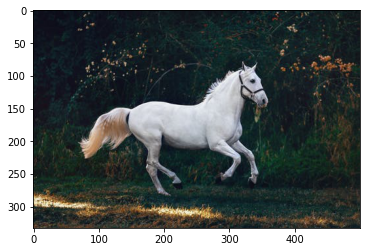

In [ ]:
image_for_inference = Image.open('/content/drive/MyDrive/upside_down/Images/horse.jpeg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = inferece_transform_visual(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(output)
print(predictions)

tensor([[4.4833]], device='cuda:0', grad_fn=<AddmmBackward0>)
[ True]


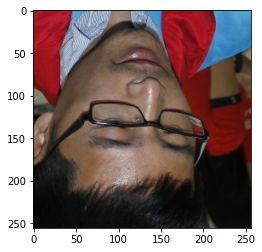

In [ ]:
image_for_inference = Image.open('/content/drive/MyDrive/upside_down/Images/upside_face.jpg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = inferece_transform_visual(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(output)
print(predictions)